# Решение системы линейных уравнений (n=12)

## Введение

Исследуем различные численные методы решения СЛАУ на примере матрицы $a_{ii}=1$, $a_{ij}=1/(i^2+j)$ при $i\ne j$. Правые части $f_i=1/i$.

Исследуемые методы:
1. Гаусс с выбором главного элемента
2. LU-разложение
3. Якоби
4. Зейдель
5. SOR (верхняя релаксация)
6. Метод наискорейшего спуска
7. Метод минимальных невязок
8. Метод сопряженных градиентов (CG)
9. Стабилизированный метод бисопряженных градиентов (BiCGStab)

## Методология

В качестве референса для вычисления нормы вектора невязки берем результат,
полученный обычным методом Гаусса.

## Исследование

Реализация всех методов решения:

In [ ]:
import math
import numpy as np


def matvec(A, x):
  n = len(A)
  y = [0.0] * n
  for i in range(n):
    s = 0.0
    ai = A[i]
    for j in range(n):
      s += ai[j] * x[j]
    y[i] = s
  return y


def matvec_transpose(A, x):
  n = len(A)
  y = [0.0] * n
  for j in range(n):
    s = 0.0
    for i in range(n):
      s += A[i][j] * x[i]
    y[j] = s
  return y


def vec_add(u, v, alpha=1.0):
  return [u_i + alpha * v_i for u_i, v_i in zip(u, v)]


def vec_sub(u, v):
  return [u_i - v_i for u_i, v_i in zip(u, v)]


def dot(u, v):
  s = 0.0
  for ui, vi in zip(u, v):
    s += ui * vi
  return s


def norm(u):
  return math.sqrt(dot(u, u))


def gaussian_elimination(A, b, eps=1e-15):
  n = len(A)
  M = [row[:] for row in A]
  bb = b[:]
  for k in range(n):
    piv = k
    maxv = abs(M[k][k])
    for i in range(k + 1, n):
      if abs(M[i][k]) > maxv:
        maxv = abs(M[i][k])
        piv = i
    if maxv < eps:
      raise ValueError("Cистема вырождена или плохо обусловлена.")
    if piv != k:
      M[k], M[piv] = M[piv], M[k]
      bb[k], bb[piv] = bb[piv], bb[k]
    for i in range(k + 1, n):
      factor = M[i][k] / M[k][k]
      for j in range(k, n):
        M[i][j] -= factor * M[k][j]
      bb[i] -= factor * bb[k]
  x = [0.0] * n
  for i in range(n - 1, -1, -1):
    s = bb[i]
    for j in range(i + 1, n):
      s -= M[i][j] * x[j]
    x[i] = s / M[i][i]
  return x


def lu_decomposition(A, b):
  n = len(A)
  M = [row[:] for row in A]
  P = list(range(n))
  L = [[0.0] * n for _ in range(n)]
  U = [[0.0] * n for _ in range(n)]
  for i in range(n):
    L[i][i] = 1.0
  for k in range(n):
    piv = k
    maxv = abs(M[k][k])
    for i in range(k + 1, n):
      if abs(M[i][k]) > maxv:
        maxv = abs(M[i][k])
        piv = i
    if maxv == 0.0:
      raise ValueError("Zero pivot in LU")
    if piv != k:
      M[k], M[piv] = M[piv], M[k]
      P[k], P[piv] = P[piv], P[k]
      for t in range(k):
        L[k][t], L[piv][t] = L[piv][t], L[k][t]
    U[k][k] = M[k][k]
    for j in range(k + 1, n):
      U[k][j] = M[k][j]
    for i in range(k + 1, n):
      L[i][k] = M[i][k] / U[k][k]
      for j in range(k + 1, n):
        M[i][j] -= L[i][k] * U[k][j]
      M[i][k] = 0.0
  Pb = [b[P[i]] for i in range(n)]
  y = [0.0] * n
  for i in range(n):
    s = Pb[i]
    for j in range(i):
      s -= L[i][j] * y[j]
    y[i] = s / L[i][i]
  x = [0.0] * n
  for i in range(n - 1, -1, -1):
    s = y[i]
    for j in range(i + 1, n):
      s -= U[i][j] * x[j]
    x[i] = s / U[i][i]
  return x, L, U, P


def jacobi(A, b, x0=None, tol=1e-10, maxit=5000):
  n = len(A)
  x = [0.0] * n if x0 is None else x0[:]
  res_list = []
  for k in range(maxit):
    x_new = x[:]
    for i in range(n):
      s = 0.0
      ai = A[i]
      for j in range(n):
        if j != i:
          s += ai[j] * x[j]
      x_new[i] = (b[i] - s) / ai[i]
    x = x_new
    r = vec_sub(b, matvec(A, x))
    res_list.append(norm(r))
    if res_list[-1] < tol:
      break
  return x, res_list


def gauss_seidel(A, b, x0=None, tol=1e-10, maxit=5000):
  n = len(A)
  x = [0.0] * n if x0 is None else x0[:]
  res_list = []
  for k in range(maxit):
    for i in range(n):
      s = 0.0
      ai = A[i]
      for j in range(n):
        if j != i:
          s += ai[j] * x[j]
      x[i] = (b[i] - s) / ai[i]
    r = vec_sub(b, matvec(A, x))
    res_list.append(norm(r))
    if res_list[-1] < tol:
      break
  return x, res_list


def sor(A, b, omega, x0=None, tol=1e-10, maxit=5000):
  n = len(A)
  x = [0.0] * n if x0 is None else x0[:]
  res_list = []
  for k in range(maxit):
    for i in range(n):
      s = 0.0
      ai = A[i]
      for j in range(n):
        if j != i:
          s += ai[j] * x[j]
      x_new_i = (b[i] - s) / ai[i]
      x[i] = (1 - omega) * x[i] + omega * x_new_i
    r = vec_sub(b, matvec(A, x))
    res_list.append(norm(r))
    if res_list[-1] < tol:
      break
  return x, res_list


def steepest_descent(A, b, x0=None, tol=1e-10, maxit=5000):
  n = len(A)
  x = [0.0] * n if x0 is None else x0[:]
  res_list = []
  for k in range(maxit):
    Ax = matvec(A, x)
    r = vec_sub(b, Ax)
    rr = dot(r, r)
    if rr == 0.0:
      res_list.append(0.0)
      break
    Ar = matvec(A, r)
    denom = dot(r, Ar)
    if abs(denom) < 1e-20:
      break
    alpha = rr / denom
    for i in range(n):
      x[i] += alpha * r[i]
    rnew = vec_sub(b, matvec(A, x))
    res_list.append(norm(rnew))
    if res_list[-1] < tol:
      break
  return x, res_list


def minimal_residuals(A, b, x0=None, tol=1e-10, maxit=5000):
  n = len(A)
  x = [0.0] * n if x0 is None else x0[:]
  res_list = []
  for k in range(maxit):
    r = vec_sub(b, matvec(A, x))
    Ar = matvec(A, r)
    denom = dot(Ar, Ar)
    if abs(denom) < 1e-20:
      break
    alpha = dot(Ar, r) / denom
    for i in range(n):
      x[i] += alpha * r[i]
    rnew = vec_sub(b, matvec(A, x))
    res_list.append(norm(rnew))
    if res_list[-1] < tol:
      break
  return x, res_list


def conjugate_gradients_normal_eq(A, b, x0=None, tol=1e-10, maxit=5000):
  n = len(A)
  x = [0.0] * n if x0 is None else x0[:]
  rhs = matvec_transpose(A, b)

  def M(v):
    return matvec_transpose(A, matvec(A, v))

  r = vec_sub(rhs, M(x))
  p = r[:]
  res_list = [norm(vec_sub(b, matvec(A, x)))]
  rr = dot(r, r)
  for k in range(1, maxit + 1):
    Mp = M(p)
    denom = dot(p, Mp)
    if abs(denom) < 1e-20:
      break
    alpha = rr / denom
    for i in range(n):
      x[i] += alpha * p[i]
    rnew = [r[i] - alpha * Mp[i] for i in range(n)]
    rr_new = dot(rnew, rnew)
    beta = rr_new / rr
    for i in range(n):
      p[i] = rnew[i] + beta * p[i]
    r = rnew
    rr = rr_new
    res_list.append(norm(vec_sub(b, matvec(A, x))))
    if res_list[-1] < tol:
      break
  return x, res_list


def bicgstab(A, b, x0=None, tol=1e-10, maxit=5000):
  n = len(A)
  x = [0.0] * n if x0 is None else x0[:]
  r = vec_sub(b, matvec(A, x))
  r0_hat = r[:]
  rho_old = alpha = omega = 1.0
  v = [0.0] * n
  p = [0.0] * n
  res_list = [norm(r)]
  for it in range(1, maxit + 1):
    rho = dot(r0_hat, r)
    if abs(rho) < 1e-20:
      break
    if it == 1:
      for i in range(n):
        p[i] = r[i]
    else:
      beta = (rho / rho_old) * (alpha / omega)
      for i in range(n):
        p[i] = r[i] + beta * (p[i] - omega * v[i])
    v = matvec(A, p)
    r0_hat_v = dot(r0_hat, v)
    if abs(r0_hat_v) < 1e-20:
      break
    alpha = rho / r0_hat_v
    s = [r[i] - alpha * v[i] for i in range(n)]
    ns = norm(s)
    if ns < tol:
      for i in range(n):
        x[i] += alpha * p[i]
      res_list.append(norm(vec_sub(b, matvec(A, x))))
      break
    t = matvec(A, s)
    t_dot_t = dot(t, t)
    if abs(t_dot_t) < 1e-20:
      break
    omega = dot(t, s) / t_dot_t
    for i in range(n):
      x[i] += alpha * p[i] + omega * s[i]
    r = [s[i] - omega * t[i] for i in range(n)]
    res_list.append(norm(r))
    rho_old = rho
    if res_list[-1] < tol or abs(omega) < 1e-20:
      break
  return x, res_list

Решаем выбранную нами систему:

In [34]:
def build_system(n=12):
  A = [[0.0] * n for _ in range(n)]
  b = [0.0] * n
  for i in range(n):
    b[i] = 1.0 / (i + 1)
    for j in range(n):
      if i == j:
        A[i][j] = 1.0
      else:
        A[i][j] = 1.0 / ((i + 1)**2 + (j + 1))
  return A, b


A, b = build_system(12)
n = len(A)
x_gauss = gaussian_elimination(A, b)
x_lu, L, U, P = lu_decomposition(A, b)
x0 = [0.0] * n
jacobi_x, jacobi_res = jacobi(A, b, x0, tol=1e-12, maxit=5000)
gs_x, gs_res = gauss_seidel(A, b, x0, tol=1e-12, maxit=5000)
sor_res_dict = {}
for omega in [1.0 + 0.1 * i for i in range(10)]:
  sx, sres = sor(A, b, omega=omega, x0=x0, tol=1e-12, maxit=5000)
  sor_res_dict[omega] = (sx, sres)
sd_x, sd_res = steepest_descent(A, b, x0, tol=1e-12, maxit=5000)
mr_x, mr_res = minimal_residuals(A, b, x0, tol=1e-12, maxit=5000)
cg_x, cg_res = conjugate_gradients_normal_eq(A, b, x0, tol=1e-12, maxit=5000)
bicg_x, bicg_res = bicgstab(A, b, x0, tol=1e-12, maxit=5000)
print("Решение (Гаусс):")
print(np.array(x_gauss))
print("Невязка ||Ax-b|| (Гаусс):", norm(vec_sub(matvec(A, x_gauss), b)))

print("\nРезультат LU (проверка):")
print(np.array(x_lu))
print("Невязка ||Ax-b|| (LU):", norm(vec_sub(matvec(A, x_lu), b)))

print("\nИтерационные методы: итераций и финальной невязки")
print("Jacobi: iters =", len(jacobi_res), " final res =",
      jacobi_res[-1] if jacobi_res else None)
print("Gauss-Seidel: iters =", len(gs_res), " final res =",
      gs_res[-1] if gs_res else None)
for omega, (sx, sres) in sor_res_dict.items():
  print(
    f"SOR(omega={omega}): iters = {len(sres)}, final res = {sres[-1] if sres else None}"
  )
print("Steepest descent: iters =", len(sd_res), " final res =",
      sd_res[-1] if sd_res else None)
print("Minimal residuals: iters =", len(mr_res), " final res =",
      mr_res[-1] if mr_res else None)
print("CG on normal eqns: iters =", len(cg_res), " final res =",
      cg_res[-1] if cg_res else None)
print("BiCGStab: iters =", len(bicg_res), " final res =",
      bicg_res[-1] if bicg_res else None)

sols = {
  'gauss': x_gauss,
  'lu': x_lu,
  'jacobi': jacobi_x,
  'gs': gs_x,
  'steepest': sd_x,
  'minres': mr_x,
  'cg': cg_x,
  'bicgstab': bicg_x
}
print(
  "\nРазности между решениями итерационных методов и решением Гаусса (норма):")
for name, xs in sols.items():
  print(name, "||x - x_gauss|| =", norm(vec_sub(xs, x_gauss)))

Решение (Гаусс):
[0.75537042 0.23879963 0.17890325 0.15086988 0.13170938 0.1170332
 0.10527117 0.09560544 0.08752166 0.08066593 0.074783   0.06968322]
Невязка ||Ax-b|| (Гаусс): 8.666675708199898e-17

Результат LU (проверка):
[0.75537042 0.23879963 0.17890325 0.15086988 0.13170938 0.1170332
 0.10527117 0.09560544 0.08752166 0.08066593 0.074783   0.06968322]
Невязка ||Ax-b|| (LU): 8.666675708199898e-17

Итерационные методы: итераций и финальной невязки
Jacobi: iters = 43  final res = 7.719759023064811e-13
Gauss-Seidel: iters = 13  final res = 9.972646587289936e-14
SOR(omega=1.0): iters = 13, final res = 9.972646587289936e-14
SOR(omega=1.1): iters = 17, final res = 1.0268349068448878e-13
SOR(omega=1.2): iters = 21, final res = 8.617017962597444e-13
SOR(omega=1.3): iters = 28, final res = 5.694106942371922e-13
SOR(omega=1.4): iters = 35, final res = 8.009480056897647e-13
SOR(omega=1.5): iters = 47, final res = 7.387393661167833e-13
SOR(omega=1.6): iters = 64, final res = 8.237383747788124e

Для иллюстрации сходимости приведем графики невязок:

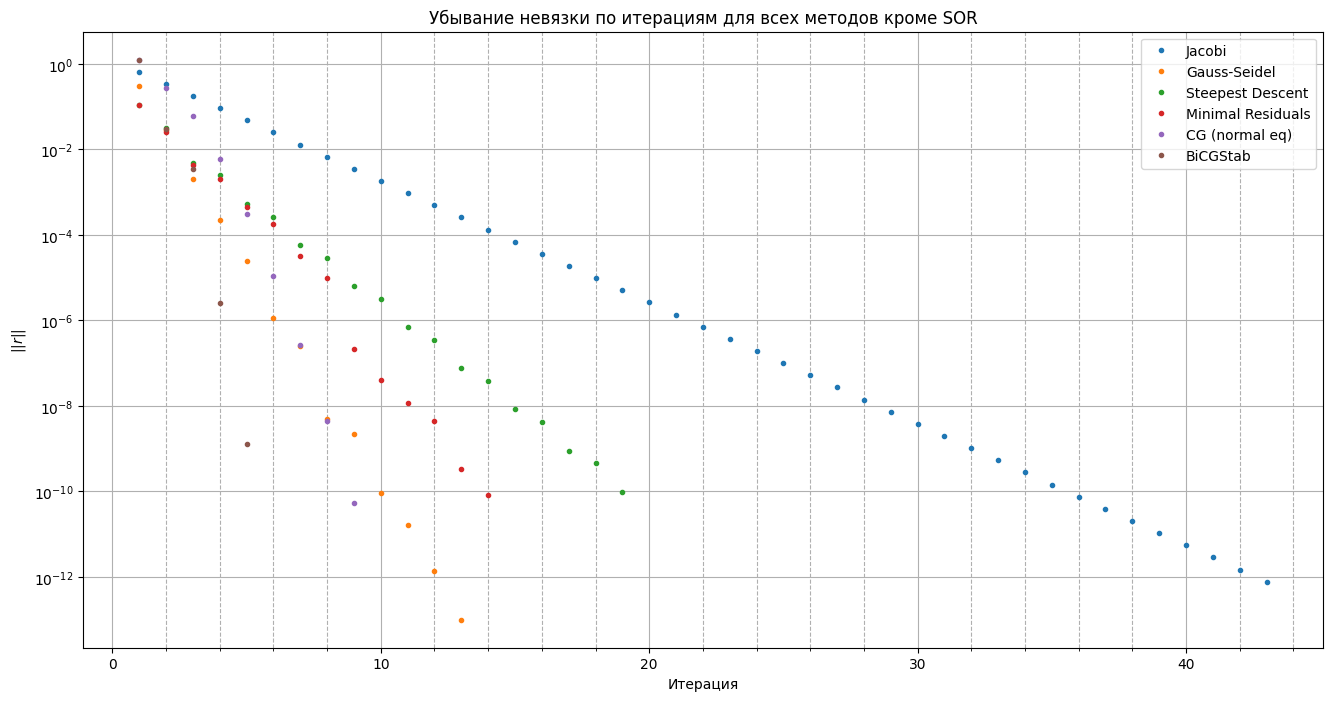

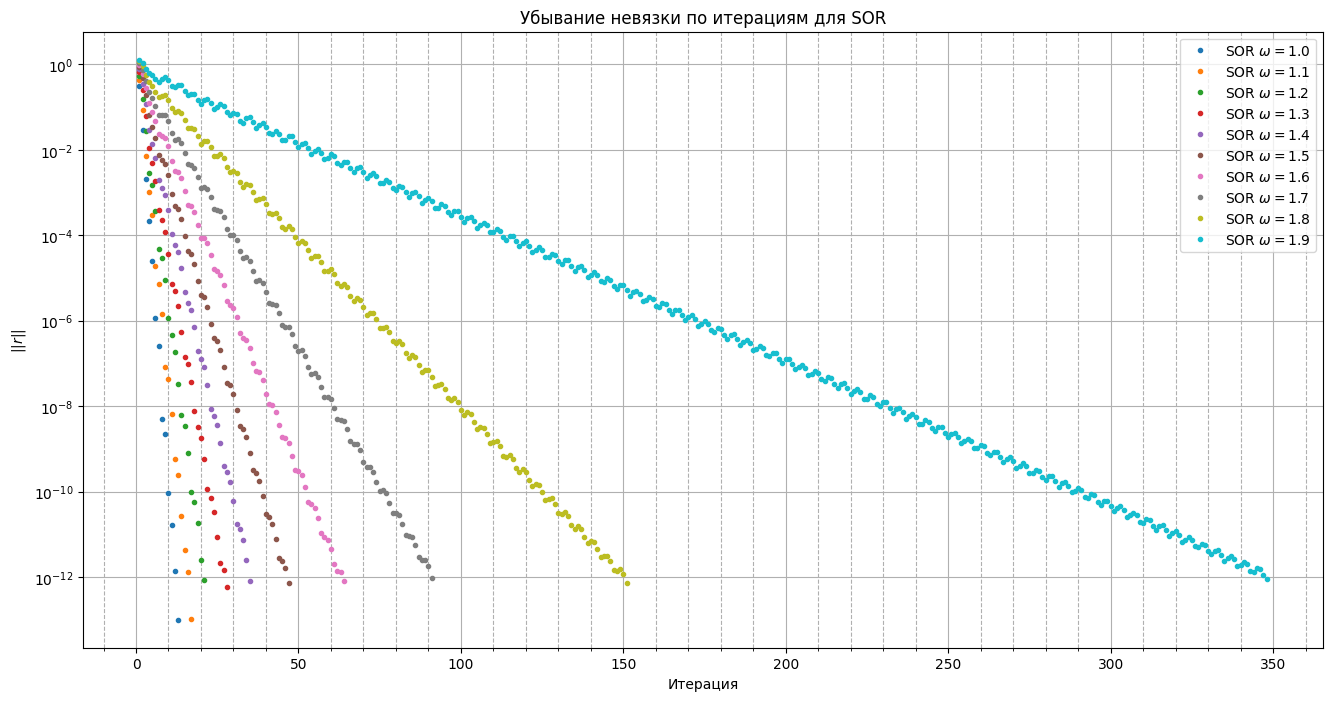

In [36]:
import matplotlib.pyplot as plt

figs, axs = [], []
for _ in range(2):
  fig, ax = plt.subplots(figsize=(16, 8))
  figs.append(fig)
  axs.append(ax)

axs[0].errorbar(range(1,
                      len(jacobi_res) + 1),
                jacobi_res,
                label='Jacobi',
                fmt='.')
axs[0].errorbar(range(1,
                      len(gs_res) + 1),
                gs_res,
                label='Gauss-Seidel',
                fmt='.')

for omega in sor_res_dict:
  sres = sor_res_dict[omega][1]
  if sres:
    axs[1].errorbar(range(1,
                          len(sres) + 1),
                    sres,
                    label=fr'SOR $\omega={omega:.1f}$',
                    fmt='.')

axs[0].errorbar(range(1,
                      len(sd_res) + 1),
                sd_res,
                label='Steepest Descent',
                fmt='.')
axs[0].errorbar(range(1,
                      len(mr_res) + 1),
                mr_res,
                label='Minimal Residuals',
                fmt='.')
axs[0].errorbar(range(1,
                      len(cg_res) + 1),
                cg_res,
                label='CG (normal eq)',
                fmt='.')
axs[0].errorbar(range(1,
                      len(bicg_res) + 1),
                bicg_res,
                label='BiCGStab',
                fmt='.')

axs[0].set_title('Убывание невязки по итерациям для всех методов кроме SOR')
axs[1].set_title('Убывание невязки по итерациям для SOR')

for ax in axs:
  ax.set_xlabel('Итерация')
  ax.set_ylabel('$||r||$')
  ax.set_yscale('log')
  ax.legend()
  ax.minorticks_on()
  ax.grid(which='major', linestyle='-')
  ax.grid(which='minor', linestyle='--')

plt.show()

## Обсуждение результатов

1. Для SOR: видно что при при убывании параметра релаксации $\omega$ скорость сходимости растет.
2. Для всех остальных: лучше всего из итерационных методов показал стабилизированный метод биспоряженных градиентов